# VIT 

This notebook is for traning a Vision Transformer model for dog emotion detection

#### REF
[VIT TIMM](https://huggingface.co/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)<br>
[Pytorch](https://pytorch.org/docs/stable/index.html)<br>
[Grad-CAM](https://github.com/jacobgil/pytorch-grad-cam/blob/master/usage_examples/vit_example.py#L55)


## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
import matplotlib.pyplot as plt
import sys
from pytorch_grad_cam import GradCAM
sys.path.insert(1, '/mnt/c/Eclipse/IU Spring 2025/is_the_dog_happy')

from get_data_loaders import *

/home/eclipse/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Visulization Functions

In [3]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

unnormalize = transforms.Normalize(
    mean=[-m/s for (m,s) in zip(MEAN, STD)],
    std =[1.0/s for s in STD]
)

In [4]:
def vis_samples(loader, rows=3, cols=3, show_mask=False, alpha=.35):
    fig = plt.figure(figsize=(cols*3, rows*3))

    for i in range(1, rows*cols+1):
        idx = torch.randint(len(loader.dataset), (1,)).item()
        img, label = loader.dataset[idx]

        # split channels
        if img.shape[0] == 4:
            rgb, mask = img[:3], img[3:]
        else:
            rgb, mask = img, None

        rgb = unnormalize(rgb.clone())
        rgb_np = rgb.permute(1,2,0).numpy().clip(0,1)

        ax = fig.add_subplot(rows, cols, i)
        ax.axis("off")
        ax.set_title(loader.dataset.classes[label])

        ax.imshow(rgb_np)

        if show_mask and mask is not None:
            m = mask.squeeze().numpy()
            ax.imshow(m, cmap="Reds", alpha=alpha)

    plt.tight_layout(); plt.show()


## Model

In [5]:
def train_model(model, train_loader, vali_loader, name="VIT"):
    creterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    num_epochs = 20
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = creterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        scheduler.step()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch: {epoch}, Loss: {avg_loss}")

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in vali_loader:
                data, target = data.to(device), target.to(device)

                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            val_accuracy = 100 * correct / total
            print(f"Validation accuracy: {val_accuracy}")

    torch.save(model.state_dict(), f"{name}.pth")

## Experiment 1: Whole Image

### Data Processing

In [6]:
train_loader, vali_loader, test_loader, num_classes = get_loaders("../data")

In [11]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

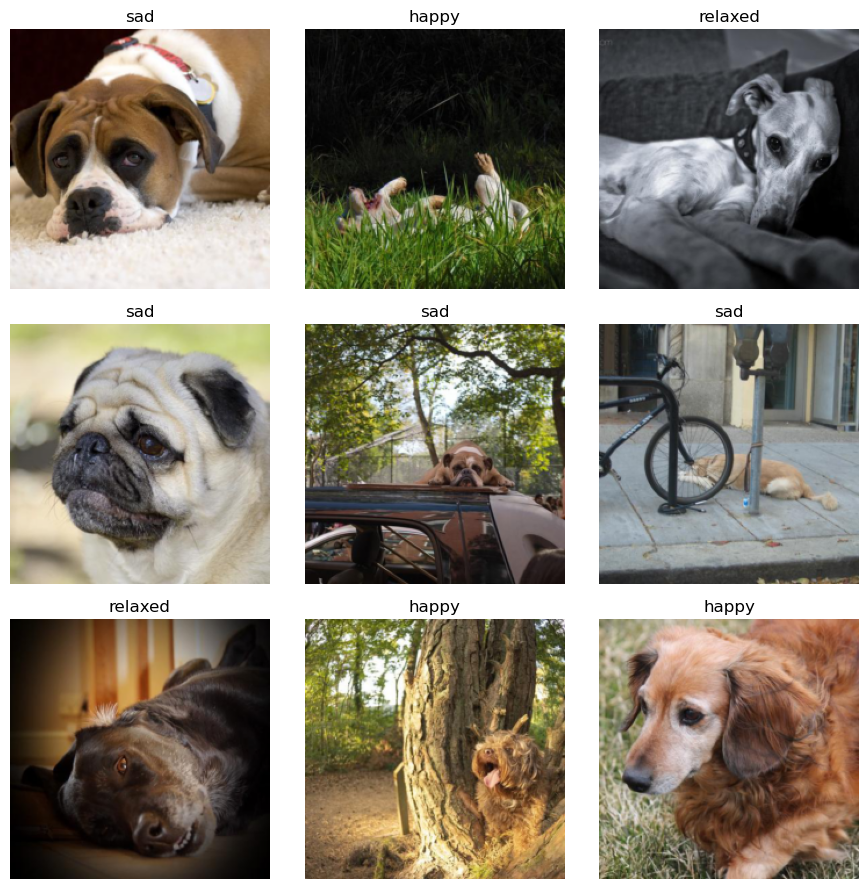

In [8]:
vis_samples(train_loader, rows=3, cols=3)

### Model Traning

In [12]:
train_model(model, train_loader, vali_loader, "vit_no_annotation")

Epoch: 0, Loss: 1.2317179897722088
Validation accuracy: 49.246231155778894
Epoch: 1, Loss: 1.1013612734213147
Validation accuracy: 51.50753768844221
Epoch: 2, Loss: 1.018677581444857
Validation accuracy: 51.915829145728644
Epoch: 3, Loss: 0.9193100128042039
Validation accuracy: 49.277638190954775
Epoch: 4, Loss: 0.7958982038737541
Validation accuracy: 49.05778894472362
Epoch: 5, Loss: 0.38959986003898894
Validation accuracy: 52.732412060301506
Epoch: 6, Loss: 0.17692122973464242
Validation accuracy: 51.9786432160804
Epoch: 7, Loss: 0.09096713282146071
Validation accuracy: 50.879396984924625
Epoch: 8, Loss: 0.05618298505947705
Validation accuracy: 52.07286432160804
Epoch: 9, Loss: 0.043973327164842015
Validation accuracy: 50.97361809045226
Epoch: 10, Loss: 0.02569755064140244
Validation accuracy: 51.50753768844221
Epoch: 11, Loss: 0.01831638520781241
Validation accuracy: 51.35050251256281
Epoch: 12, Loss: 0.01715402829021951
Validation accuracy: 50.97361809045226
Epoch: 13, Loss: 0.0138

## Experiment 2: Face Annotations with only Oxford weights

### Data Pre-processing

In [6]:
train_loader_f_anno, vali_loader_f_anno, test_loader_f_anno, num_classes_f_anno = get_loaders("../data", "../annotations_face")

[TOO FEW POINTS] ../annotations_face/train/angry/108546979_4f9d9027da_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/1117094770_06bfef2e1b_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/11355642185_1f20878def_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/11755637014_9276d6b152_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/1221584616_5b161bdee6_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/12580049984_95dbed9108_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/12983203414_98d81df780_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/1394076163_82f57c279a_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face/train/angry/14269444564_f0e763d3ac_b.txt – found 0 values, need 

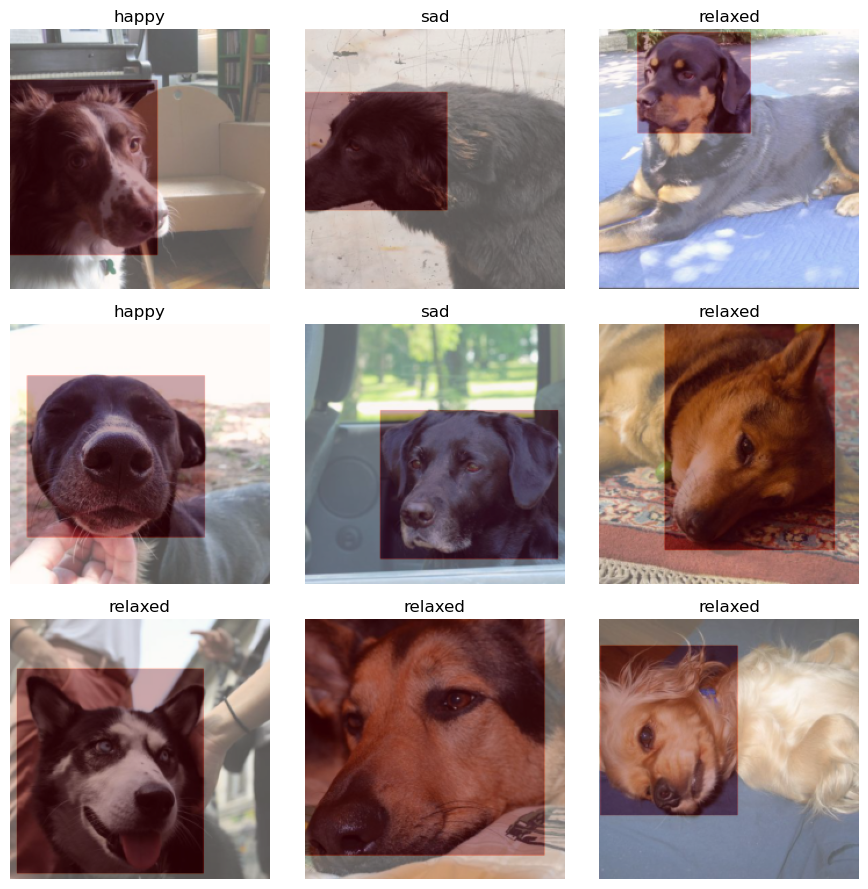

In [7]:
vis_samples(train_loader_f_anno, rows=3, cols=3, show_mask=True)

In [10]:
model_f_anno = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes_f_anno)
in_ch = model_f_anno.patch_embed.proj.in_channels 

model_f_anno.patch_embed.proj = torch.nn.Conv2d(
    4, model_f_anno.patch_embed.proj.out_channels,
    kernel_size=16, stride=16
)

model_f_anno.head = torch.nn.Linear(model_f_anno.head.in_features, 4)
model_f_anno = model_f_anno.to(device)

In [11]:
train_model(model_f_anno, train_loader_f_anno, vali_loader_f_anno, "vit_face_oxford_annotated")

Epoch: 0, Loss: 1.3872112952077758
Validation accuracy: 37.01808256567724
Epoch: 1, Loss: 1.346145859615833
Validation accuracy: 40.293415216649606
Epoch: 2, Loss: 1.323194157664676
Validation accuracy: 40.600477652678265
Epoch: 3, Loss: 1.297829406834691
Validation accuracy: 43.432275673831455
Epoch: 4, Loss: 1.2579069924701975
Validation accuracy: 38.451040600477654
Epoch: 5, Loss: 1.201062253915547
Validation accuracy: 47.765267826680315
Epoch: 6, Loss: 1.166620284698917
Validation accuracy: 45.752302968270214
Epoch: 7, Loss: 1.1328714407424023
Validation accuracy: 46.29819174343228
Epoch: 8, Loss: 1.0895124338363689
Validation accuracy: 46.40054588877516
Epoch: 9, Loss: 1.0110687150981257
Validation accuracy: 45.786421016717846
Epoch: 10, Loss: 0.7796065642859766
Validation accuracy: 42.920504947117024
Epoch: 11, Loss: 0.5821515431386742
Validation accuracy: 42.71579665643125
Epoch: 12, Loss: 0.39744081111363594
Validation accuracy: 42.16990788126919
Epoch: 13, Loss: 0.259930071561

## Experiment 3: Face annotations with Imagenet weights

### Data Preprocessing

In [8]:
train_loader_fc_anno, vali_loader_fc_anno, test_loader_fc_anno, num_classes_fc_anno = get_loaders("../data", "../annotations_face_combined")

[TOO FEW POINTS] ../annotations_face_combined/train/angry/10069504164_436856871c_b.txt – found 0 values, need 4, skipping


[TOO FEW POINTS] ../annotations_face_combined/train/angry/108546979_4f9d9027da_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face_combined/train/angry/1117094770_06bfef2e1b_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face_combined/train/angry/11274022893_0e7f4efd98_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face_combined/train/angry/12159388703_5d0f795921_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face_combined/train/angry/12161423665_bdb766331a_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face_combined/train/angry/13776821454_c5ffe7a378_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face_combined/train/angry/15306303584_b22ce98491_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotations_face_combined/train/angry/16113386094_f29cae5a8b_b.txt – found 0 values, need 4, skipping
[TOO FEW POINTS] ../annotat

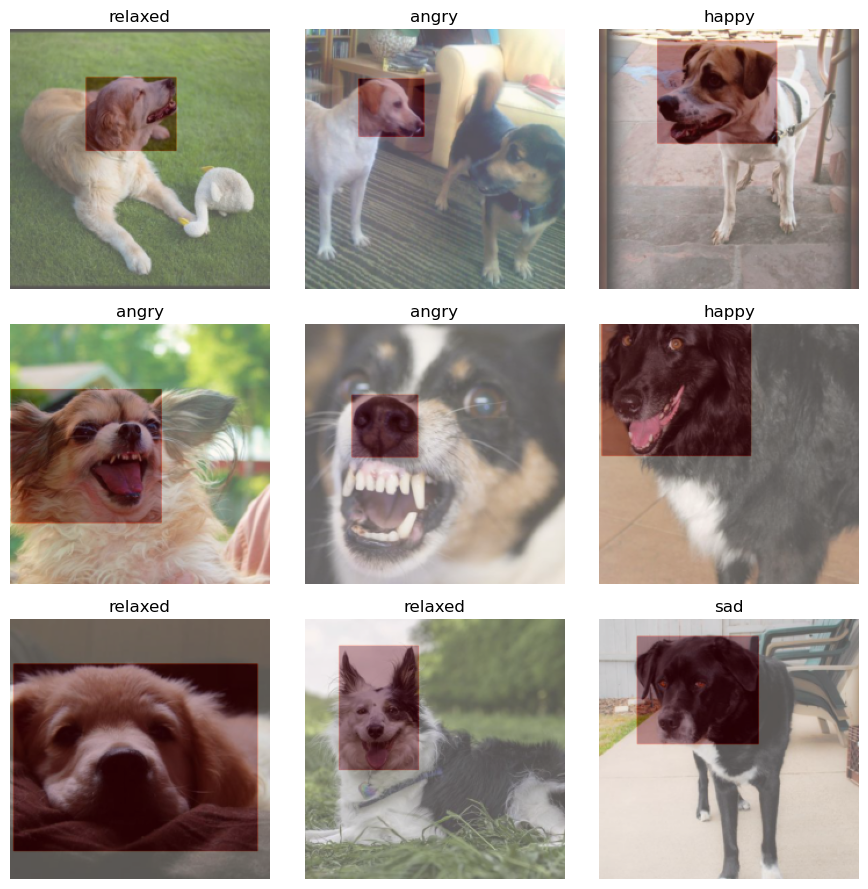

In [9]:
vis_samples(train_loader_fc_anno, rows=3, cols=3, show_mask=True)

In [12]:
model_fc_anno = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes_fc_anno)
in_ch = model_fc_anno.patch_embed.proj.in_channels 

model_fc_anno.patch_embed.proj = torch.nn.Conv2d(
    4, model_fc_anno.patch_embed.proj.out_channels,
    kernel_size=16, stride=16
)

model_fc_anno.head = torch.nn.Linear(model_fc_anno.head.in_features, 4)
model_fc_anno = model_fc_anno.to(device)

In [13]:
train_model(model_fc_anno, train_loader_fc_anno, vali_loader_fc_anno, "vit_face_combined_annotated")

Epoch: 0, Loss: 1.383280797207609
Validation accuracy: 30.211480362537763
Epoch: 1, Loss: 1.3465691168680258
Validation accuracy: 37.66364551863041
Epoch: 2, Loss: 1.3164132685526042
Validation accuracy: 42.26250419603894
Epoch: 3, Loss: 1.2894538930544617
Validation accuracy: 42.799597180261834
Epoch: 4, Loss: 1.2612585469763329
Validation accuracy: 44.343739509902655
Epoch: 5, Loss: 1.2039925627251888
Validation accuracy: 45.720040281973816
Epoch: 6, Loss: 1.1726674701727875
Validation accuracy: 44.041624706277275
Epoch: 7, Loss: 1.1362820845757815
Validation accuracy: 45.115810674723065
Epoch: 8, Loss: 1.0918536827707968
Validation accuracy: 44.343739509902655
Epoch: 9, Loss: 1.0141446867310409
Validation accuracy: 46.05572339711313
Epoch: 10, Loss: 0.7602415727385392
Validation accuracy: 41.255454850621014
Epoch: 11, Loss: 0.5576593763201584
Validation accuracy: 42.56461899966432
Epoch: 12, Loss: 0.3658895103710023
Validation accuracy: 41.725411211816045
Epoch: 13, Loss: 0.22319919